# Problem Definition and EDA

Computer vision, object detection and classification are some of the most popular and interesting problems in Machine Learning. The good thing is that they are easily applicable to real life problems. In this research we'll try to build the best possible classifier that will tell us what type of breed is on the picture of the dog. 

It feels like everyone is having a dog nowadays and I've always wondered about the breed while walking down the street or park.

## Dataset

People have been "mixing" (for the lack of better word) dogs for centuries. The exact number known to us varies from source to source. Different google searches displayed different results. But the number is more than 400 and less than 2000, at least in my last search. Most of them were between 400 and 500 so we'll accept this for the moment.

Trying to find the appropriate data wasn't easy. Thankfully Tensorflow Datasets Api came along so this process is rather easy. Let's actually see what we have to deal with it. 

In [2]:
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt

In [3]:
dataset, info = tfds.load(name="stanford_dogs", with_info=True, shuffle_files=True)

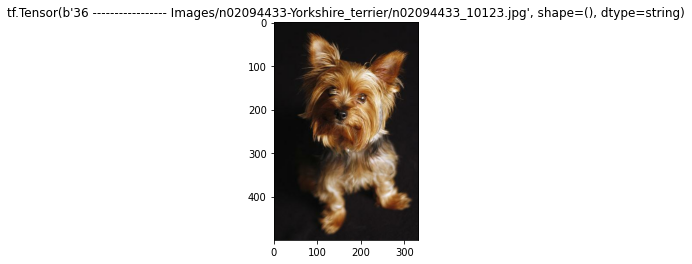

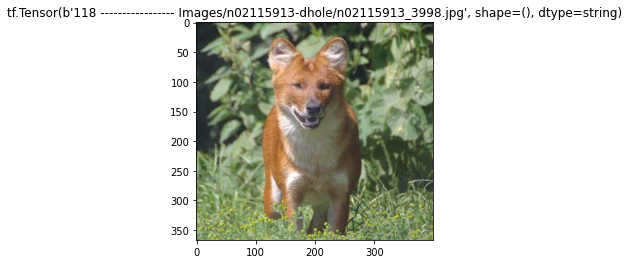

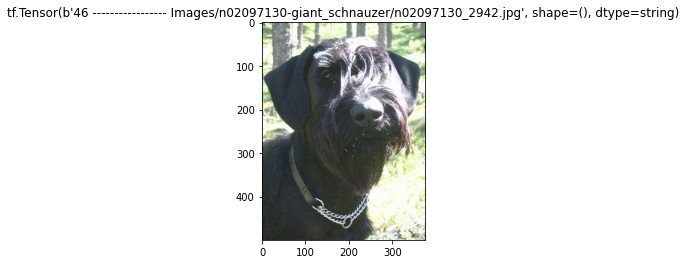

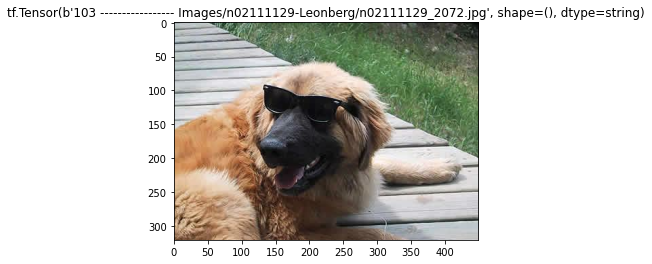

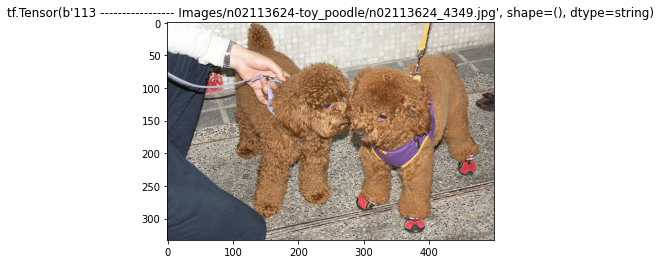

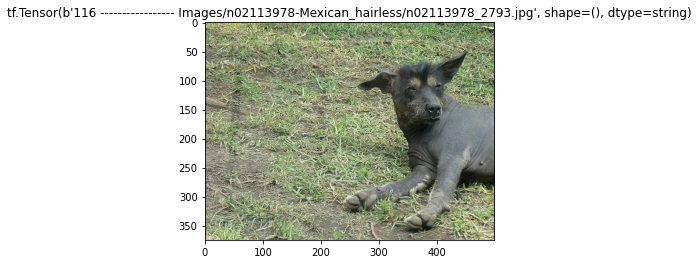

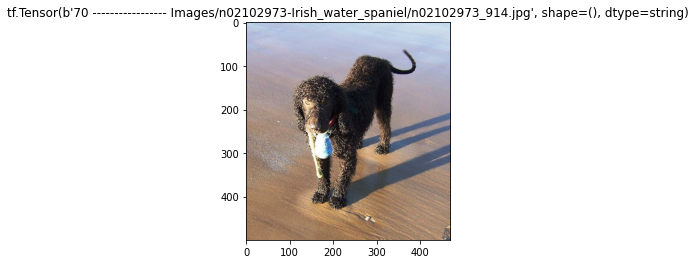

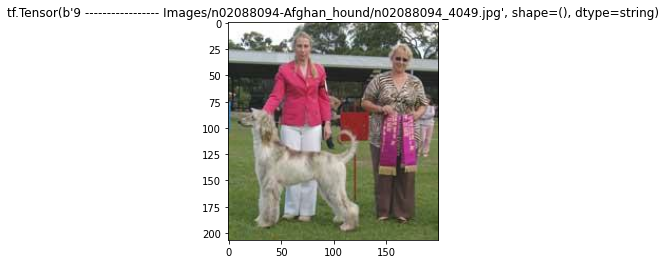

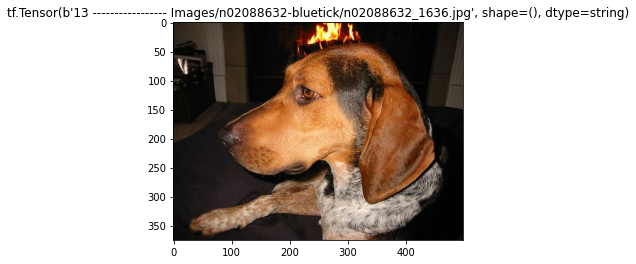

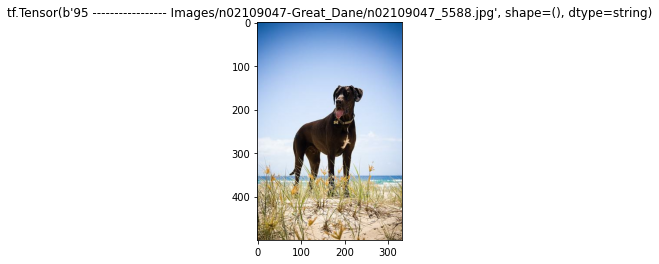

In [4]:
sample_of_10 = []
for x in dataset['train'].take(10):
  plt.imshow(x['image'])
  sample_of_10.append(x['image'])
  plt.title(str(x['label'].numpy()) + " ----------------- "+  x['image/filename'])
  plt.show()


---
I only show 10 random pictures here but I examined much more than that while trying to get the names of labels(surprisingly there were nowhere to be found in Internet).

## EDA

Let's make an EDA of the Data with a bit bigger sample. 100 should be enough. It's image dataset so the dimensions are crucial and most problematic so let's start with it.

In [5]:
sample_of_100 = [x['image'] for x in dataset['train'].take(100)]

In [6]:
arr_of_heights = [x.shape[0] for x in sample_of_100]
arr_of_widths = [x.shape[1] for x in sample_of_100]


In [7]:
def get_dimensions(arr_of_heights, arr_of_widths, title1, title2):
  plt.hist(arr_of_heights)
  plt.xlabel('Height')
  plt.ylabel('Count')
  plt.title(title1)
  plt.show()

  plt.hist(arr_of_widths)
  plt.xlabel('Width')
  plt.ylabel('Count')
  plt.title(title2)
  plt.show()

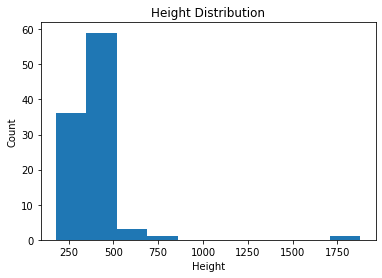

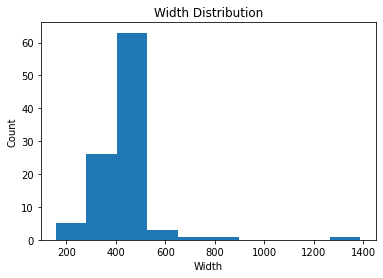

In [8]:
get_dimensions(arr_of_heights, arr_of_widths, 'Height Distribution', 'Width Distribution')


---
Aparently we'll have to resize the data since it varies a lot. Even in this relatively small sample of 100 we found a very distant outlier 3 times bigger than the average. How do we resize it? We'll answer that at the end of this notebook.

Another problem is dealing with the colors. You'll often see in such type of tasks researchers to get rid of some of the dimensions by turning the images intro gray ones. This, I'm afraid, is not an option here. The colors should be of extreme importance for the model. Some of the breeds are very hard to distinguish from one another. So we'll need and use this information to its fullest extent. 

Now let's check the raw numbers.


In [9]:
info

tfds.core.DatasetInfo(
    name='stanford_dogs',
    version=0.2.0,
    description='The Stanford Dogs dataset contains images of 120 breeds of dogs from around
the world. This dataset has been built using images and annotation from
ImageNet for the task of fine-grained image categorization. There are
20,580 images, out of which 12,000 are used for training and 8580 for
testing. Class labels and bounding box annotations are provided
for all the 12,000 images.',
    homepage='http://vision.stanford.edu/aditya86/ImageNetDogs/main.html',
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=tf.uint8),
        'image/filename': Text(shape=(), dtype=tf.string),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=120),
        'objects': Sequence({
            'bbox': BBoxFeature(shape=(4,), dtype=tf.float32),
        }),
    }),
    total_num_examples=20580,
    splits={
        'test': 8580,
        'train': 12000,
    },
    supervised_keys=('image'

So we have about 12000 for training and 8580 for test. Not much for 120 labels.. Turning this into a dataframe or numpy is very ram consuming so we can't display graphically the number of observations for each label but you can find them here on the left:

http://vision.stanford.edu/aditya86/ImageNetDogs/

Every single breed is presented by at least 150 images so at least that's good. We are not going to take any actions in that direction for now. 

So finally - we'll make a data augmentation for sure, we'll use the provided 'test' split for validation in place and the real test we'll be performed in a very client-friendly way by putting pictures from urls directly from internet. A good idea is also to build a small application with Flask or something to test it this way.

Check the accuracy per class here from official source:

![Accuracy per Class](http://vision.stanford.edu/aditya86/ImageNetDogs/bar_graph_full.png)

## Strategy to solve the problem


### Previous Work

This dataset is among the difficult ones for classification. It has very small amount of observations, some of them are too big, there are people in it, even different breeds on the same picture. 

Some of the most popular places to get a good idea of what's been achieved so far:

https://paperswithcode.com/sota/fine-grained-image-classification-on-stanford-1

http://vision.stanford.edu/aditya86/ImageNetDogs/

https://www.kaggle.com/c/dog-breed-identification/notebooks


## Transfer Learning Choice

You can observe in Kaggle notebook some interesting attempts to build a model from scratch. But the best performances are by already established models. This is what we are going to do here as well. 

The one that we'll focus on is Inception-Resnet. As the name applies, it consists of residuals connections of the original Microsoft model and the efficiency of the Google convolutional neural net. It hasn't been tested on this dataset to my knowledge or at least couldn't find papers or repo's so it's uncharted watters which is good. 

The model provided by Keras API is trained on ImageNet, the source of our dataset as well, so getting the weights we'll be easy. We'll use the common practice in Transfer learning by freezing the convolutional layers + the final Average Pooling in our case and we'll only make the setup to work for our dataset. Different architectures will be tried while performing hyperparameter tuning. We'll add two different fully connected layers before the softmax layer, one before the softmax and one directly with softmax layer after the convolutions.